# 📖 👆🏻 Printed Links Detection Using TensorFlow 2 Object Detection API

![Links Detector Cover](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/01-banner.png)

## 📃 TL;DR

_In this article we will start solving the issue of making the printed links (i.e. in a book or in a magazine) clickable via your smartphone camera._

We will use TensorFlow 2 [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to train a custom object detector model to find positions and bounding boxes of the sub-strings like `https://` in the text image (i.e. in smartphone camera stream).

The text of each link (right continuation of `https://` bounding box) will be recognized by using [Tesseract](https://tesseract.projectnaptha.com/) library. The recognition part will not be covered in this article but you may find the complete code example of the application in [links-detector repository](https://github.com/trekhleb/links-detector).   

> 🚀 [**Launch Links Detector demo**](https://trekhleb.github.io/links-detector/) from your smartphone to see the final result.

> 📝 [**Open links-detector repository**](https://github.com/trekhleb/links-detector) on GitHub to see the complete source code of the application.

Here is how the final solution will look like:

![Links Detector Demo](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/03-links-detector-demo.gif)

> ⚠️ Currently the application is in _experimental_ _Alpha_ stage and has [many issues and limitations](https://github.com/trekhleb/links-detector/issues?q=is%3Aopen+is%3Aissue+label%3Aenhancement). So don't raise your expectations bar to high until these issues are resolved 🤷🏻‍. Also the pruspose of this article is more about learning how to work with TensorFlow 2 Object Detection API rather than comming up with a production ready model.

## 🤷🏻‍♂️ The Problem

I work as a software engineer and on my own time I learn Machine Learning as a hobby. But this is not the problem yet.

I bought a printed book about Machine Learning recently and while I was reading through the first several chapters I've encountered many printed links in the text that looked like `https://tensorflow.org/` or `https://some-url.com/which/may/be/even/longer?and_with_params=true`.

![Printed Links](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/02-printed-links.jpg)

I saw all these links but I couldn't click on them since they were printed (thanks, cap!). To visit these links I needed to start typing them character by character in the browser's address bar, which was pretty annoying and error prone.

## 💡 Possible Solution

So, what if, similarly to QR-code detection, we will try to "teach" the smartphone to _(1)_ _detect_ and _(2)_ _recognize_ printed links for us and also to make them _clickable_? This way you'll do just one click instead of multiple keystrokes. The operational complexity goes from `O(N)` to `O(1)`.

This is how the final workflow will look like:

![Links Detector Demo](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/03-links-detector-demo.gif)

## 📝 Solution Requirements

As I've mentioned earlier I'm just studying a Machine Learning as a hobby. Thus the pruspose of this article is more about _learning_ how to work with TensorFlow 2 Object Detection API rather than comming up with a production ready application.

With that beign said, I simplified the solution requirements to the following:

1. The detection and recognition processes should have a **close-to-real-time** performance (i.e. `0.5-1` frames per second) on a device like iPhone X. It means that whole _detection + recognition_ process should take up to `2` seconds (preatty bearable as for the amateur project).
2. Only **English** links should be supported.
3. Only **dark text** (i.e. black or dark-grey) on **light background** (i.e. white or light-grey) should be supported.
4. Only `https://` links should be supported for now (it is ok if our model will not recognize the `http://`, `ftp://`, `tcp://` or other types of links).

## 🧩 Solution Breakdown

### High-level breakdown

Let's see how we could approach the problem on a high level.

#### Option 1: Detection model on the back-end

**The flow:**

1. Get camera stream (frame by frame) on the client side.
2. Send each frame one by one over the network to the back-end.
3. Do links detection and recognition on the back-end and send the response back to the client.
4. Client draws the detection boxes with the clickable links.

![Model on the back-end](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/04-frontend-backend.jpg)

**Pros:**

- 💚 The detection performance is not limited by the client's device. We may speed the detection up by scaling the service horizontally (adding more instances) and vertically (adding more cores/GPUs).
- 💚 The model might be bigger since there is no need to upload it to the client side. Downloading the `~10Mb` model on the client side may be ok, but loading the `~100Mb` model might be a big issue for the client's network and application UX (user experience) otherwise.
- 💚 It is possible to controll who is using the model. Model is guarded behind the API so we would have complete controll over its callers/clients.

**Cons:**

- 💔 System complexity growth. The aplication tech stack growth from just `JavaScript` to, let's say, `JavaScript + Python`. We need to take care about the autoscaling.
- 💔 Offline mode for the app is not possible since it needs an internet connection to work.
- 💔 Too many HTTP requests between the client and the server may become a bottleneck at some point. Imagine if we would want to improve the performance of the detecton, let's say, from `1` to `10+` frames per second. This means that each client will send `10+` requests per second. For `10` simultanious clients it is already `100+` requests per second. The `HTTP/2` bidirectional streaming and `gRPC` might be useful in this case, but we're going back to increased system complexity here.  
- 💔 System becomes more expensive. Almost all points from Pros section need to be paid for.

#### Option 2: Detection model on the front-end

**The flow:**

1. Get camera stream (frame by frame) on the client side.
2. Do links detection and recognition on the client side (without sending anything to the back-end).
3. Client draws the detection boxes with the clickable links.

![Model on the front-end](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/05-frontend-only.jpg)

**Pros:**

- 💚 System is less complex. We don't need to set up the servers, build the API and introcude an additional Python stack to the system. 
- 💚 Offline mode is possible. The app doesn't need an internet connection to work since the model is loaded on the device. So the Progressive Web Application ([PWA](https://web.dev/progressive-web-apps/)) might be built to support that.
- 💚 System is "kind of" scaling automatically. The more clients you have, the more cores and GPUs they bring. This is not a proper scaling solution though (more about that in a Cons section below). 
- 💚 System is cheaper. We only need a server for static assets (`HTML`, `JS`, `CSS`, model files etc.). This may be done for free, let's say, on GitHub.
- 💚 No issue with the growing number of HTTP requests per second to the server side.

**Cons:**

- 💔 Only the horizontal scaling is possible (each client will have it's own CPU/GPU). Vertical scaling is not possible since we can't influence the client's device performance. As a result we can't guarantee fast detection for low performant devices.
- 💔 It is not possible to guard the model usage and controll the callers/clients of the model. Everyone could download the model and re-use it. 
- 💔 Battery consumption of the client's device might become an issue. For the model to work it needs computational resources. So clients might not be happy with their iPhone getting warmer and warmer while the app is working.

#### High-level conslusion

Since the purpose of the project was more about learning and not comming up with a production ready solution _I decided to go with the second option of serving the model from the client side_. This made the whole project much cheaper (actually with the GitHub it was free to host it) and I could focus more on Machine Learning then on the autoscaling back-end infrastructure.


### Lower level breakdown

Ok, so we've decided to go with the serverless solution. And now we have an image from the camera stream as an input that looks something like this:

![Printed Links Input](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/06-printed-links-clean.jpg)

We need to solve two sub-tasks for this image:

1. Links **detection** (finding the position and bounding boxes of the links)
2. Links **recognition** (recognizing the text of the links)

#### Option 1: Tesseract based solution

The first and the most obvious aproach would be to solve the _Optical Character Recognition_ ([OCR](https://en.wikipedia.org/wiki/Optical_character_recognition)) task by recognizing the whole text of the image by using, let's say, [Tesseract.js](https://github.com/naptha/tesseract.js) library. As a pleasent bonus it returns the bounding boxes of the paragraphs, text lines and text blocks along with the recognized text.

![Recognized text with bounding boxes](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/07-printed-links-boxes.jpg)

Then we may try to extract the links from the recognized text lines or text blocks with a regular expression like [this one](https://stackoverflow.com/questions/3809401/what-is-a-good-regular-expression-to-match-a-url):

```typescript
const URL_REG_EXP = /https?:\/\/(www\.)?[-a-zA-Z0-9@:%._+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_+.~#?&/=]*)/gi;

const extractLinkFromText = (text: string): string | null => {
  const urls: string[] | null = text.match(URL_REG_EXP);
  if (!urls || !urls.length) {
    return null;
  }
  return urls[0];
};
```

💚 Seems like the issue is solved in a pretty straightforward and simple way:

- We know the bounding boxes of the links
- And we also know the text of the links to make them clickable

💔 The thing is that the _recognition + detection_ time may vary from `2` to `20+` seconds depending on the size of the text, on the ammount of "something that looks like a text" on the image, on the image quality and on other factors. So it will be realy hard to achive those `0.5-1` frames per second to make the user experience at least _close_ to the real-time.

💔 Also if we would think about it, we're asking the library to recognize the **whole** text from the image for us even though it might contain only one or two links in it (i.e. only ~10% of the text might be usefull for us) or it may even not contain the links at all. In this case it sounds like a waste of the computational resources. 

#### Option 2: Tesseract + TensorFlow based solution

We could make Tesseract work faster if we used some _additional "adviser" algorithm_ in prior to the links text recognition. This "adviser" algorithm should detect, but not recognize, _the the leftmost position_ of each link on the image if there are any. This will allow us to speed up the recognition part by following these rules:

1. If the image does not contain any link we should not call Tesseract detection/recognition at all.
2. If the image does have the links then we need to ask Tesseract to recognize only those parts of the image that contains the links. We're not interested in spending time for recognition of the irrelevant text that doesn't contain the links.

The "adviser" algorithm that will take place before the Tesseract should work with a constant time regardless of the image quality or the presence/absence of the text on the image. It also should be pretty fast and detect the leftmost positions of the links for less then `1s` so that we could satisfy the "close-to-real-time" requirement (i.e. on iPhone X).

> 💡 So what if we will use another object detection model to help us find all occurrences of the `https://` substrings (every secure link has this prefix, doesn't it) in the image? Then, having these `https://` bounding boxes in the text we may extract the right-side continuation of them and send them to the Tesseract for text recognition.

Take a look at the picture below:

![Tesseract and TensorFlow based solution](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/08-tesseract-vs-tensorflow.jpg)

You may notice that Tesseract needs to do **much less** work in case if it would have some hints about where are the links might be located (see the number of blue boxes on both pictures).

So the question now is which object detection model we should choose and how to re-train it to support the detection of the custom `https://` objects.  

> Finally! We've got closer to the TensorFlow part of the article 😀


## 🤖 Selecting the object detection model

Training a new object detection model is not a reasonable option in our context because of the following reasons:

- 💔 The training process might take days/weeks and bucks.
- 💔 We most probably won't be able to collect houndreds of thouthands of _labeled_ images of the books that have links in them (we might try to generate them though, but more about that later). 

So instead of creating a new model we should better teach an existing object detection model to do the custom object detection for us (to do the [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning)). In our case the "custom objects" would be the images with `https://` text drawn in them. This approach has the following benefits:

- 💚 The dataset might be much smaller. We don't need to collect houndreds of thouthands of the labeled images. Instead we may do `~100` pictures and label them manually. This is because the model is already pre-trained on the general dataset like [COCO dataset](https://cocodataset.org/#home) and already learned how to extract general image features.
- 💚 The training process will be much faster (minutes/hours on GPU instead of days/weeks). Again, this is because of a smaller dataset and because of fewer trainable parameters.

We may choose the existing model from [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) which provides a collection of detection models pre-trained on the [COCO 2017 dataset](https://cocodataset.org/#home). For now it contains `~40` model variations to choose from.

To re-train and fine-tune the model on the custom dataset we will use a [TensorFlow 2 Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). The TensorFlow Object Detection API is an open source framework built on top of [TensorFlow](https://www.tensorflow.org/) that makes it easy to construct, train and deploy object detection models.

If you follow the [Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) link you will find the _detection speed_ and _accuracy_ for each model.

![Model Zoo](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/09-model-zoo.jpg)

_Image source: [TensorFlow Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) repository_

Of course we would want to find the right balance between the detection **speed** and **accuracy** while picking the model. But what might be even more important in our case is the **size** of the model since it will be loaded to the client side.

The size of the archived model might vary drastically from `~20Mb` to `~1Gb`. Here are several examples:

- `1386 (Mb)` `centernet_hg104_1024x1024_kpts_coco17_tpu-32`
- ` 330 (Mb)` `centernet_resnet101_v1_fpn_512x512_coco17_tpu-8`
- ` 195 (Mb)` `centernet_resnet50_v1_fpn_512x512_coco17_tpu-8`
- ` 198 (Mb)` `centernet_resnet50_v1_fpn_512x512_kpts_coco17_tpu-8`
- ` 227 (Mb)` `centernet_resnet50_v2_512x512_coco17_tpu-8`
- ` 230 (Mb)` `centernet_resnet50_v2_512x512_kpts_coco17_tpu-8`
- `  29 (Mb)` `efficientdet_d0_coco17_tpu-32`
- `  49 (Mb)` `efficientdet_d1_coco17_tpu-32`
- `  60 (Mb)` `efficientdet_d2_coco17_tpu-32`
- `  89 (Mb)` `efficientdet_d3_coco17_tpu-32`
- ` 151 (Mb)` `efficientdet_d4_coco17_tpu-32`
- ` 244 (Mb)` `efficientdet_d5_coco17_tpu-32`
- ` 376 (Mb)` `efficientdet_d6_coco17_tpu-32`
- ` 376 (Mb)` `efficientdet_d7_coco17_tpu-32`
- ` 665 (Mb)` `extremenet`
- ` 427 (Mb)` `faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8`
- ` 424 (Mb)` `faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8`
- ` 337 (Mb)` `faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8`
- ` 337 (Mb)` `faster_rcnn_resnet101_v1_640x640_coco17_tpu-8`
- ` 343 (Mb)` `faster_rcnn_resnet101_v1_800x1333_coco17_gpu-8`
- ` 449 (Mb)` `faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8`
- ` 449 (Mb)` `faster_rcnn_resnet152_v1_640x640_coco17_tpu-8`
- ` 454 (Mb)` `faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8`
- ` 202 (Mb)` `faster_rcnn_resnet50_v1_1024x1024_coco17_tpu-8`
- ` 202 (Mb)` `faster_rcnn_resnet50_v1_640x640_coco17_tpu-8`
- ` 207 (Mb)` `faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8`
- ` 462 (Mb)` `mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8`
- `  86 (Mb)` `ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8`
- `  44 (Mb)` `ssd_mobilenet_v2_320x320_coco17_tpu-8`
- `  20 (Mb)` `ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8`
- `  20 (Mb)` `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8`
- ` 369 (Mb)` `ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8`
- ` 369 (Mb)` `ssd_resnet101_v1_fpn_640x640_coco17_tpu-8`
- ` 481 (Mb)` `ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8`
- ` 480 (Mb)` `ssd_resnet152_v1_fpn_640x640_coco17_tpu-8`
- ` 233 (Mb)` `ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8`
- ` 233 (Mb)` `ssd_resnet50_v1_fpn_640x640_coco17_tpu-8`

The **`ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8`** model might be a good fit for our case:

- 💚 It is relativelly lightweight: `20Mb` archived.
- 💚 It is pretty fast: `39ms` for the detection.
- 💚 It uses MobileNet v2 network as a feature extractor which is optimized for usage on mobile devices and with lower energy consumption.
- 💚 It does the objects detection for the whole image and for the all objects in it **in one go** regardless of the image content. 
- 💔 It is not the most accurate model though (everythin is a tradeof ⚖️).

The model name encodes its several important characteristics that you may read more about if you want:

- The expected image input size is `640x640px`.
- The model implements [Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) (SSD) and [Feature Pyramid Network](https://arxiv.org/abs/1612.03144) (FPN).
- [MobileNet v2](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html) convolutional neural network ([CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network)) is used as a feature extractor.
- The model was trained on [COCO dataset](https://cocodataset.org/#home)



##### Scripts

In [ ]:
import os
import pathlib
import tensorflow as tf

LOAD_MODELS = False

def _model_zoo():
    CACHE_FOLDER = './models_zoo'
    DATASETS_FOLDER = os.path.join(CACHE_FOLDER, 'datasets')

    MODEL_NAMES = [
    #   'centernet_hg104_512x512_kpts_coco17_tpu-3',
    'centernet_hg104_1024x1024_kpts_coco17_tpu-32',
    'centernet_resnet50_v1_fpn_512x512_coco17_tpu-8',
    'centernet_resnet50_v1_fpn_512x512_kpts_coco17_tpu-8',
    'centernet_resnet101_v1_fpn_512x512_coco17_tpu-8',
    'centernet_resnet50_v2_512x512_coco17_tpu-8',
    'centernet_resnet50_v2_512x512_kpts_coco17_tpu-8',
    'efficientdet_d0_coco17_tpu-32',
    'efficientdet_d1_coco17_tpu-32',
    'efficientdet_d2_coco17_tpu-32',
    'efficientdet_d3_coco17_tpu-32',
    'efficientdet_d4_coco17_tpu-32',
    'efficientdet_d5_coco17_tpu-32',
    'efficientdet_d6_coco17_tpu-32',
    'efficientdet_d7_coco17_tpu-32',
    'ssd_mobilenet_v2_320x320_coco17_tpu-8',
    'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8',
    'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
    'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8',
    'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8',
    'ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8',
    'ssd_resnet101_v1_fpn_640x640_coco17_tpu-8',
    'ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8',
    'ssd_resnet152_v1_fpn_640x640_coco17_tpu-8',
    'ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8',
    'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8',
    'faster_rcnn_resnet50_v1_1024x1024_coco17_tpu-8',
    'faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8',
    'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8',
    'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8',
    'faster_rcnn_resnet101_v1_800x1333_coco17_gpu-8',
    'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8',
    'faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8',
    'faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8',
    'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8',
    'faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8',
    'mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8',
    'extremenet',
    ];

    def create_cache(folder_name):
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

    def download_tf_model(model_name, cache_path):
        TF_MODELS_BASE_PATH = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
        model_url = TF_MODELS_BASE_PATH + model_name + '.tar.gz'
        model_dir = tf.keras.utils.get_file(
            fname=model_name, 
            origin=model_url,
            untar=False,
            cache_dir=pathlib.Path(cache_path).absolute()
        )
        return model_dir

    def download_models(model_names, cache_path):
        for model_name in model_names:
            download_tf_model(model_name, cache_path)

    def ls(base_dir):
        KB = 1024
        MB = KB * KB
        names = os.listdir(base_dir)
        sizes = [(name, os.stat(os.path.join(base_dir, name)).st_size) for name in sorted(names)]
        for (name, size) in sizes:
            size_mb = round(size / MB)
            print('- `{:>4} (Mb)` `{}`'.format(size_mb, name))

    create_cache(CACHE_FOLDER)
    download_models(MODEL_NAMES, CACHE_FOLDER)
    ls(DATASETS_FOLDER)

if LOAD_MODELS:
    _model_zoo()

## 🛠 Installing Object Detection API 

In this article we're going to install the Tensorflow 2 Object Detection API _as a Python package_. It is convenient in case if you're experimenting in [Google Colab](https://colab.research.google.com/) (recommended) or in [Jupyter](https://jupyter.org/try). For both cases no local installation is needed, you may experiment right in your browser.

You may also follow the [official documentation](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md) if you would preffer to install Object Detection API via Docker.

First, let's clone the [API repository](https://github.com/tensorflow/models):

```bash
git clone --depth 1 https://github.com/tensorflow/models
```

_output →_

```
Cloning into 'models'...
remote: Enumerating objects: 2301, done.
remote: Counting objects: 100% (2301/2301), done.
remote: Compressing objects: 100% (2000/2000), done.
remote: Total 2301 (delta 561), reused 922 (delta 278), pack-reused 0
Receiving objects: 100% (2301/2301), 30.60 MiB | 13.90 MiB/s, done.
Resolving deltas: 100% (561/561), done.
```

Now, let's compile the [API proto files](https://github.com/tensorflow/models/tree/master/research/object_detection/protos) into Python files by using [protoc](https://grpc.io/docs/protoc-installation/) tool:

```bash
cd ./models/research
protoc object_detection/protos/*.proto --python_out=.
```

And finally, let's install the TF2 version of [setup.py](https://github.com/tensorflow/models/blob/master/research/object_detection/packages/tf2/setup.py) via `pip`:

```bash
cp ./object_detection/packages/tf2/setup.py .
pip install . --quiet
```

> It is possible that the last step will fail because of some dependency errors. In this case you might want to run `pip install . --quiet` one more time.

We may test that installation went successfully by running the following tests:

```bash
python object_detection/builders/model_builder_tf2_test.py
```

You should see the logs that end with something similar to this:

```
[       OK ] ModelBuilderTF2Test.test_unknown_ssd_feature_extractor
----------------------------------------------------------------------
Ran 20 tests in 45.072s

OK (skipped=1)
```

The TensorFlow Object Detection API is installed! You may now use the scripts that API provides for doing the model [inference](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb), [training](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_training_and_evaluation.md) or [fine-tunning](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb).

##### Scripts

In [2]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2314, done.
remote: Counting objects: 100% (2314/2314), done.
remote: Compressing objects: 100% (2013/2013), done.
remote: Total 2314 (delta 566), reused 927 (delta 277), pack-reused 0
Receiving objects: 100% (2314/2314), 30.63 MiB | 26.43 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [3]:
%%bash
cd ./models/research
protoc object_detection/protos/*.proto --python_out=.
cp ./object_detection/packages/tf2/setup.py .
pip install . --quiet

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.25.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1; python_version >= "3.0", but you'll have avro-python3 1.10.0 which is incompatible.


In [4]:
%%bash
cd ./models/research
pip install . --quiet

In [5]:
%%bash
cd ./models/research
python object_detection/builders/model_builder_tf2_test.py

2020-11-27 12:36:12.750321: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2020-11-27 12:36:15.197134: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-27 12:36:15.255269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-27 12:36:15.255910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-11-27 12:36:15.255968: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully o

## ⬇️ Downloading the Pre-Trained Model

Let's download our selected `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8` model from the TensorFlow Model Zoo and check how it does the general objects detection (detection of the object classes from COCO dataset like "cat", "dog", "car", etc.).

We will use the [get_file()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) TensorFlow helper to download the archived model from the URL and unpack it.

```python
import tensorflow as tf
import pathlib

MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
TF_MODELS_BASE_PATH = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
CACHE_FOLDER = './cache'

def download_tf_model(model_name, cache_folder):
    model_url = TF_MODELS_BASE_PATH + model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path(cache_folder).absolute()
    )
    return model_dir

# Start the model download.
model_dir = download_tf_model(MODEL_NAME, CACHE_FOLDER)
print(model_dir)
```

_output →_

```
/content/cache/datasets/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8
```

Here is how the folder structure looks so far:

![Cache Folder](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/10-cache-folder.jpg)

The `checkpoint` folder contains the snapshot of pre-trained model.

The `pipeline.config` file contains the detection settings of the model. We'll come back to this file later when we will need to fine-tune the model.

##### Scripts

In [ ]:
rm -rf sample_data/

In [ ]:
mkdir -p ./cache

In [ ]:
import tensorflow as tf
import pathlib

MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
TF_MODELS_BASE_PATH = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
CACHE_FOLDER = './cache'

def download_tf_model(model_name, cache_folder):
    model_url = TF_MODELS_BASE_PATH + model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path(cache_folder).absolute()
    )
    return model_dir

# Start the model downloading.
model_dir = download_tf_model(MODEL_NAME, CACHE_FOLDER)
print(model_dir)

20520960/20518283 [==============================] - 0s 0us/step
/content/cache/datasets/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8


In [ ]:
def get_folder_size(folder_path):
    mB = 1000000
    root_dir = pathlib.Path(folder_path)
    sizeBytes = sum(f.stat().st_size for f in root_dir.glob('**/*') if f.is_file())
    return f'{sizeBytes//mB} MB'

print(f'Unpacked model size: {get_folder_size(model_dir)}')


Unpacked model size: 31 MB


## 🏄🏻‍♂️ Trying the Model (the Inference)

For now the model can detect the object of [90 COCO dataset classes](https://cocodataset.org/#explore) like a `car`, `bird`, `hot dog` etc.

![COCO classes](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/11-coco-classes.jpg)

_Image sourse: [COCO dataset](https://cocodataset.org/#explore) website_

Let's see how the model performs for some general images that contain the objects of these classes.

### Loading COCO labels

Object Detection API already has a complete set of COCO labels (classes) defined for us.

```python
import os

# Import Object Detection API helpers.
from object_detection.utils import label_map_util

# Loads the COCO labels data (class names and indices relations).
def load_coco_labels():
    # Object Detection API already has a complete set of COCO clases defined for us.
    label_map_path = os.path.join(
        'models/research/object_detection/data',
        'mscoco_complete_label_map.pbtxt'
    )
    label_map = label_map_util.load_labelmap(label_map_path)

    # Class ID to Class Name mapping.
    categories = label_map_util.convert_label_map_to_categories(
        label_map,
        max_num_classes=label_map_util.get_max_label_map_index(label_map),
        use_display_name=True
    )
    category_index = label_map_util.create_category_index(categories)
    
    # Class Name to Class ID mapping.
    label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

    return category_index, label_map_dict

# Load COCO labels.
coco_category_index, coco_label_map_dict = load_coco_labels()

print('coco_category_index:', coco_category_index)
print('coco_label_map_dict:', coco_label_map_dict)
```

_output →_

```
coco_category_index:
{
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    ...
    90: {'id': 90, 'name': 'toothbrush'},
}

coco_label_map_dict:
{
    'background': 0,
    'person': 1,
    'bicycle': 2,
    'car': 3,
    ...
    'toothbrush': 90,
}
```

### Build a detection function

We need to create a detection function that will use the pre-trained model that we've downloaded to do the object detection.

```python
import tensorflow as tf

# Import Object Detection API helpers.
from object_detection.utils import config_util
from object_detection.builders import model_builder

# Generates the detection function for specific model and specific model's checkpoint
def detection_fn_from_checkpoint(config_path, checkpoint_path):
    # Build the model.
    pipeline_config = config_util.get_configs_from_pipeline_file(config_path)
    model_config = pipeline_config['model']
    model = model_builder.build(
        model_config=model_config,
        is_training=False,
    )

    # Restore checkpoints.
    ckpt = tf.compat.v2.train.Checkpoint(model=model)
    ckpt.restore(checkpoint_path).expect_partial()

    # This is a function that will do the detection.
    @tf.function
    def detect_fn(image):
        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)

        return detections, prediction_dict, tf.reshape(shapes, [-1])
    
    return detect_fn

inference_detect_fn = detection_fn_from_checkpoint(
    config_path=os.path.join('cache', 'datasets', MODEL_NAME, 'pipeline.config'),
    checkpoint_path=os.path.join('cache', 'datasets', MODEL_NAME, 'checkpoint', 'ckpt-0'),
)
```

### Loading the images for inference

Let's try to detect the object on this image:

![General Object Inference](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/12-inference-01.jpg)

_Image source: [oleksii_trekhleb](https://www.instagram.com/oleksii_trekhleb/?hl=en) Instagram_

To do that let's save the image to the `inference/test/` folder of our project. If you're using Google Colab you may create this folder and upload the image manually.

Here is how the folder structure looks so far:

![Folder strcuture](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/14-inference-folders.jpg)

```python
import matplotlib.pyplot as plt
%matplotlib inline

# Creating a TensorFlow dataset of just one image.
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='inference',
  image_size=(640, 640),
  batch_size=1,
  shuffle=False,
  label_mode=None
)
# Numpy version of the dataset.
inference_ds_numpy = list(inference_ds.as_numpy_iterator())

# You may preview the images in dataset like this.
plt.figure(figsize=(14, 14))
for i, image in enumerate(inference_ds_numpy):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image[0].astype("uint8"))
    plt.axis("off")
plt.show()
```

### Running the detection on test data

Now we're ready to run the detection.

```python
detections, predictions_dict, shapes = inference_detect_fn(
    inference_ds_numpy[0]
)
```

Let's see the shapes of the output:

```python
boxes = detections['detection_boxes'].numpy()
scores = detections['detection_scores'].numpy()
classes = detections['detection_classes'].numpy()
num_detections = detections['num_detections'].numpy()[0]

print('boxes.shape: ', boxes.shape)
print('scores.shape: ', scores.shape)
print('classes.shape: ', classes.shape)
print('num_detections:', num_detections)
```

_output →_

```
boxes.shape:  (1, 100, 4)
scores.shape:  (1, 100)
classes.shape:  (1, 100)
num_detections: 100.0
```

The model made a `100` detections for us. The bounding boxes for each detection are stored in the `boxes` array. The scores or a confidences of the model about each detection are stored in the `scores` array. And finally the `classes` array stores the labels (classes) for each detection.

Let's check the first 5 detections:

```python
print('First 5 boxes:')
print(boxes[0,:5])

print('First 5 scores:')
print(scores[0,:5])

print('First 5 classes:')
print(classes[0,:5])

class_names = [coco_category_index[idx + 1]['name'] for idx in classes[0]]
print('First 5 class names:')
print(class_names[:5])
```

_output →_

```
First 5 boxes:
[[0.17576033 0.84654826 0.25642633 0.88327974]
 [0.5187813  0.12410264 0.6344235  0.34545377]
 [0.5220358  0.5181462  0.6329132  0.7669856 ]
 [0.50933677 0.7045719  0.5619138  0.7446198 ]
 [0.44761637 0.51942706 0.61237675 0.75963426]]

First 5 scores:
[0.6950246 0.6343004 0.591157  0.5827219 0.5415643]

First 5 classes:
[9. 8. 8. 0. 8.]

First 5 class names:
['traffic light', 'boat', 'boat', 'person', 'boat']
```

The model sees the traffic light, several boats and a person on the image. And we may confirm that indeed these object are seen on the image. 

Let's visualize the detection boxes:

```python
# Importing Object Detection API helpers.
from object_detection.utils import visualization_utils

# Visualizes the bounding boxes on top of the image.
def visualize_detections(image_np, detections, category_index):
    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.4,
        agnostic_mode=False,
    )

    plt.figure(figsize=(12, 16))
    plt.imshow(image_np_with_detections)
    plt.show()

# Visualizing the detections.
visualize_detections(
    image_np=tf.cast(inference_ds_numpy[0][0], dtype=tf.uint32).numpy(),
    detections=detections,
    category_index=coco_category_index,
)
```

Here is the output:

![Inference result](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/14-inference-results-01.jpg)

If we will do the detection for the text image here is what we will see:

![Inference result for text image](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/15-inference-results-02.jpg)

The model couldn't detect anyting on this image. This is what we're going to change, we want to teach the model to "see" the `https://` prefixes on this image.

##### Scripts

In [ ]:
import os

# Import Object Detection API helpers.
from object_detection.utils import label_map_util

# Loads the COCO labels data (class names and indices relations).
def load_coco_labels():
    # Object Detection API already has a complete set of COCO clases defined for us.
    label_map_path = os.path.join(
        'models/research/object_detection/data',
        'mscoco_complete_label_map.pbtxt'
    )
    label_map = label_map_util.load_labelmap(label_map_path)

    # Class ID to Class Name mapping.
    categories = label_map_util.convert_label_map_to_categories(
        label_map,
        max_num_classes=label_map_util.get_max_label_map_index(label_map),
        use_display_name=True
    )
    category_index = label_map_util.create_category_index(categories)
    
    # Class Name to Class ID mapping.
    label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

    return category_index, label_map_dict

# Load COCO labels.
coco_category_index, coco_label_map_dict = load_coco_labels()

print('coco_category_index:')
print(coco_category_index)

print()

print('coco_label_map_dict:')
print(coco_label_map_dict)

coco_category_index:
{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 12: {'id': 12, 'name': '12'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 26: {'id': 26, 'name': '26'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 29: {'id': 29, 'name': '29'}, 30: {'id': 3

In [ ]:
import tensorflow as tf

# Import Object Detection API helpers.
from object_detection.utils import config_util
from object_detection.builders import model_builder

# Generates the detection function for specific model and specific model's checkpoint
def detection_fn_from_checkpoint(config_path, checkpoint_path):
    # Build the model.
    pipeline_config = config_util.get_configs_from_pipeline_file(config_path)
    model_config = pipeline_config['model']
    model = model_builder.build(
        model_config=model_config,
        is_training=False,
    )

    # Restore checkpoints.
    ckpt = tf.compat.v2.train.Checkpoint(model=model)
    ckpt.restore(checkpoint_path).expect_partial()

    # This is a function that will do the detection.
    @tf.function
    def detect_fn(image):
        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)

        return detections, prediction_dict, tf.reshape(shapes, [-1])
    
    return detect_fn

inference_detect_fn = detection_fn_from_checkpoint(
    config_path=os.path.join('cache', 'datasets', MODEL_NAME, 'pipeline.config'),
    checkpoint_path=os.path.join('cache', 'datasets', MODEL_NAME, 'checkpoint', 'ckpt-0'),
)

Found 2 files belonging to 2 classes.


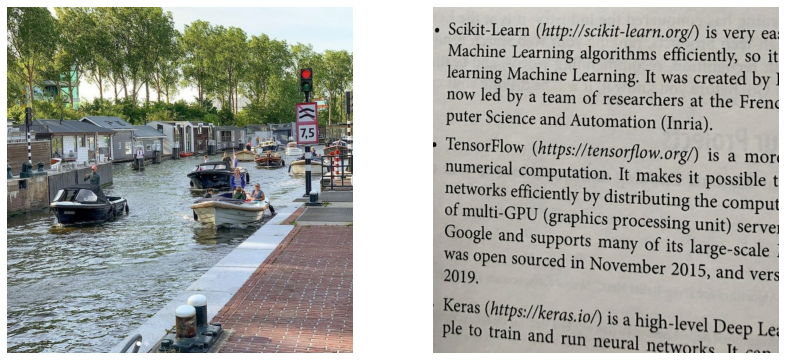

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Creating a TensorFlow dataset of just one image.
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='inference',
  image_size=(640, 640),
  batch_size=1,
  shuffle=False,
  label_mode=None
)
# Numpy version of the dataset.
inference_ds_numpy = list(inference_ds.as_numpy_iterator())

# You may preview the images in dataset like this.
plt.figure(figsize=(14, 14))
for i, image in enumerate(inference_ds_numpy):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image[0].astype("uint8"))
    plt.axis("off")
plt.show()

In [ ]:
# Run the detection.
detections, predictions_dict, shapes = inference_detect_fn(
    inference_ds_numpy[0]
)

In [ ]:
boxes = detections['detection_boxes'].numpy()
scores = detections['detection_scores'].numpy()
classes = detections['detection_classes'].numpy()
num_detections = detections['num_detections'].numpy()[0]

print('boxes.shape: ', boxes.shape)
print('scores.shape: ', scores.shape)
print('classes.shape: ', classes.shape)
print('num_detections:', num_detections)

boxes.shape:  (1, 100, 4)
scores.shape:  (1, 100)
classes.shape:  (1, 100)
num_detections: 100.0


In [ ]:
print('First 5 boxes:')
print(boxes[0,:5])

print()

print('First 5 scores:')
print(scores[0,:5])

print()

print('First 5 classes:')
print(classes[0,:5])

print()

class_names = [coco_category_index[idx + 1]['name'] for idx in classes[0]]
print('First 5 class names:')
print(class_names[:5])

First 5 boxes:
[[0.17576033 0.84654826 0.25642633 0.88327974]
 [0.5187813  0.12410264 0.6344235  0.34545377]
 [0.5220358  0.5181462  0.6329132  0.7669856 ]
 [0.50933677 0.7045719  0.5619138  0.7446198 ]
 [0.44761637 0.51942706 0.61237675 0.75963426]]

First 5 scores:
[0.6950246 0.6343004 0.591157  0.5827219 0.5415643]

First 5 classes:
[9. 8. 8. 0. 8.]

First 5 class names:
['traffic light', 'boat', 'boat', 'person', 'boat']


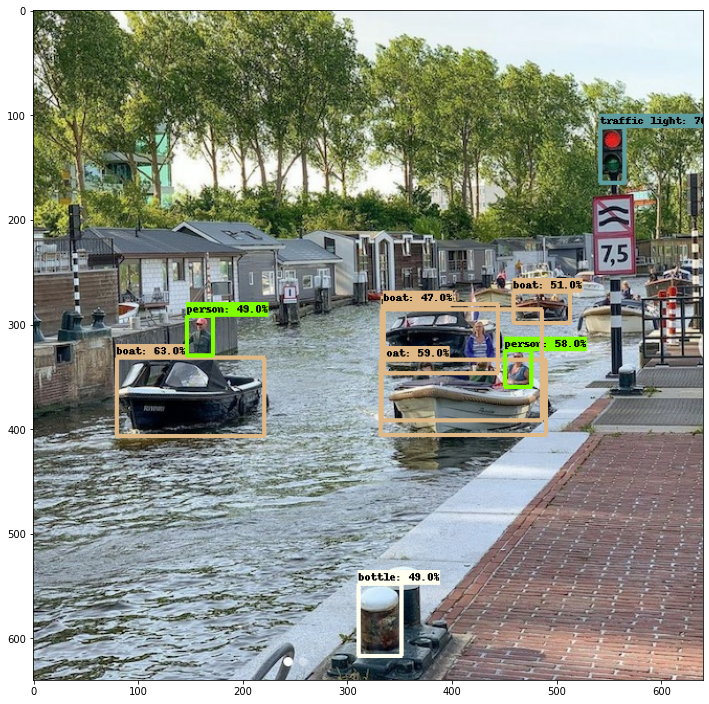

In [ ]:
# Importing Object Detection API helpers.
from object_detection.utils import visualization_utils

# Visualizes the bounding boxes on top of the image.
def visualize_detections(image_np, detections, category_index):
    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.4,
        agnostic_mode=False,
    )

    plt.figure(figsize=(12, 16))
    plt.imshow(image_np_with_detections)
    plt.show()

# Visualizing the detections.
visualize_detections(
    image_np=tf.cast(inference_ds_numpy[0][0], dtype=tf.uint32).numpy(),
    detections=detections,
    category_index=coco_category_index,
)

## 📝 Preparing the Custom Dataset

To "teach" the `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8` model to detect the custom objects which are _not_ a part of a COCO dataset we need to fine-tune it on a new custom dataset.

The datasets for object detection mostly consist of two parts:

1. The image itself (i.e. the image of the book page)
2. The boundary boxes that shows where exactly on the image the custom object are located.

![Bounding Boxes](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/16-detection-boxes.jpg)

In the example above each box has `left-top` and `right-bottom` coordinates in _absolute_ values (in pixels). However there are also different formats of writing the location of the bounding boxes exist. For example we may locate the bounding box by setting the coordinate of its `center point` and its `width` and `height`. We might also use _relative_ values (percentage of the width and height of the image) for setting up the coordinates. But you got the idea, the network needs to know what the image is and where on the image the objects are located.

Now, how can we get the custom dataset for training? We have three options here:

1. Re-use the existing dataset.
2. Create the dataset by generating a fake book images.
3. Create the dataset manually by taking or downloading the pictures of real book pages which contain `https://` links and labeling all bounding boxes.

### Option 1: Re-using the existing dataset

There are plenty of the datasets that are shared to be re-used by researches. We could start fromthe following resources to find a proper dataset:

- [Google Dataset Search](https://datasetsearch.research.google.com/)
- [Kaggle Datasets](https://www.kaggle.com/datasets)
- [awesome-public-datasets](https://github.com/awesomedata/awesome-public-datasets) repository
- etc.

💚 If you could find the needed dataset and its license allows you to re-use it, it is probably the fastest way to get streight to the model training.

💔 I couldn't find the dataset with labeled `https://` prefixes thoguh.

So we need to skip this option.

### Option 2: Generating the synthetic dataset

There are tools exists (i.e. [keras_ocr](https://keras-ocr.readthedocs.io/en/latest/examples/end_to_end_training.html#generating-synthetic-data)) that might help us to generate random text, include the link in it and draw it on an images with some background and disturtions.

💚 The cool part about this aproach is that we have a freedom to generate training examples for different _fonts_, _ligatures_, _text colors_, _background colors_. This is very usefull if we want to avoid the [model overfitting](https://en.wikipedia.org/wiki/Overfitting) during the training (so that the model could generalize well to unseen real-world examples instead of failing once the background shade is changed for a bit).

💚 It is also possible to generate a variety of link types like `http://`, `http://`, `ftp://`, `tcp://` etc. Otherwise it might be hard to find enough real world examples of these kind of links for training.

💚 Another benefit of this approach is that we could generate as many training examples as we want. We're not limited to the number of pages of the printed book we've found for the dataset.

💔 It is possible though to misuse the generator and to generate the training images that will be quite different from real world examples. Let's say we may use the wrong and unrealistic distortions for the page (i.e. using waves bend instead of the arc one). In this case model will not generalize well to real-world examples.

> I see this approach as a really promissing one. It may help to overcome many model issues (more on that below). I didn't try it yet though. But it might be a good candidate for another article.

### Option 3: Creating the dataset manually

The most streightforward way though is to get the book (or books), to make the pictures of the pages with the links and to label all of them manually.

The good news is that the dataset might be pretty small (houndreds of images might be enough) because we're not going to train the model _from scratch_ but instead we're going to do a [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) (also see the [few-shot learning](https://paperswithcode.com/task/few-shot-learning).)

💚 In this case the training dataset will be really close to real-world data. You will literaly take the printed book, make a picture of it with realistic fonts, bends, shades, perspectives and colors.

💔 Even though it doesn't require a lot images it may still be time-consuming

💔 It is hard to come up with a diverse database where training examples would have different fonts, background colors and different types of links (we need to find many diverse books and magazines to accomplish that).

Since the article has a learning purpose and since we're not trying to win an object detection competition let's go with this option for now and try to create a dataset by ourselves.

### Preprocessing the data

So I've ended up shooting a `125` images of the book pages that contains one or more `https://` links on them.

![Raw Dataset](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/17-dataset-raw.jpg)

I put all these images to `dataset/printed_links/raw` folder.

Next, I'm going to preprocess the images by doing the following:

- **Resize** each image to the width of `1024px` (they are too big originally and have a width of `3024px`)
- **Crop** each image to make them squared (this is optional and we could just resize the image by simply squeezing it, but I want the model to train on realistic proportions of `https:` boxes).
- **Rotate** image if needed by applying the [exif](https://en.wikipedia.org/wiki/Exif) metadata.
- **Greyscale** the image (we don't need the model to take the colors into consideration).
- **Increase brightness**
- **Increase brightness**
- **Increase sharpness**

Remember, that once we've decided to apply these transformations and adjustments to the dataset we need to do the same in the future for each image that we will send to the model for detection.

Here is how we could apply these adjustments to the image using Python:

```python
import os
import math
import shutil

from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance

# Resize an image.
def preprocess_resize(target_width):
    def preprocess(image: Image.Image, log) -> Image.Image:
        (width, height) = image.size
        ratio = width / height

        if width > target_width:
            target_height = math.floor(target_width / ratio)
            log(f'Resizing: To size {target_width}x{target_height}')
            image = image.resize((target_width, target_height))
        else:
            log('Resizing: Image already resized, skipping...')

        return image
    return preprocess

# Crop an image.
def preprocess_crop_square():
    def preprocess(image: Image.Image, log) -> Image.Image:
        (width, height) = image.size
        
        left = 0
        top = 0
        right = width
        bottom = height
        
        crop_size = min(width, height)
        
        if width >= height:
            # Horizontal image.
            log(f'Squre cropping: Horizontal {crop_size}x{crop_size}')
            left = width // 2 - crop_size // 2
            right = left + crop_size
        else:
            # Vetyical image.
            log(f'Squre cropping: Vertical {crop_size}x{crop_size}')
            top = height // 2 - crop_size // 2
            bottom = top + crop_size

        image = image.crop((left, top, right, bottom))
        return image
    return preprocess

# Apply exif transpose to an image.
def preprocess_exif_transpose():
    # @see: https://pillow.readthedocs.io/en/stable/reference/ImageOps.html
    def preprocess(image: Image.Image, log) -> Image.Image:
        log('EXif transpose')
        image = ImageOps.exif_transpose(image)
        return image
    return preprocess

# Apply color transformations to the image.
def preprocess_color(brightness, contrast, color, sharpness):
    # @see: https://pillow.readthedocs.io/en/3.0.x/reference/ImageEnhance.html
    def preprocess(image: Image.Image, log) -> Image.Image:
        log('Coloring')
        
        enhancer = ImageEnhance.Color(image)
        image = enhancer.enhance(color)

        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(brightness)
        
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(contrast)
        
        enhancer = ImageEnhance.Sharpness(image)
        image = enhancer.enhance(sharpness)
        
        return image
    return preprocess

# Image pre-processing pipeline.
def preprocess_pipeline(src_dir, dest_dir, preprocessors=[], files_num_limit=0, override=False):
    # Create destination folder if not exists.
    Path(dest_dir).mkdir(parents=False, exist_ok=True)
    
    # Get the list of files to be copied.
    src_file_names = os.listdir(src_dir)
    files_total = files_num_limit if files_num_limit > 0 else len(src_file_names)
    files_processed = 0
    
    # Logger function.
    def preprocessor_log(message):
        print('  ' + message)
    
    # Iterate through files.
    for src_file_index, src_file_name in enumerate(src_file_names):
        if files_num_limit > 0 and src_file_index >= files_num_limit:
            break
            
        # Copy file.        
        src_file_path = os.path.join(src_dir, src_file_name)
        dest_file_path = os.path.join(dest_dir, src_file_name)
        
        progress = math.floor(100 * (src_file_index + 1) / files_total)
        print(f'Image {src_file_index + 1}/{files_total} | {progress}% |  {src_file_path}')
        
        if not os.path.isfile(src_file_path):
            preprocessor_log('Source is not a file, skipping...\n')
            continue
        
        if not override and os.path.exists(dest_file_path):
            preprocessor_log('File already exists, skipping...\n')
            continue
            
        shutil.copy(src_file_path, dest_file_path)
        files_processed += 1
        
        # Preprocess file.
        image = Image.open(dest_file_path)
        
        for preprocessor in preprocessors:
            image = preprocessor(image, preprocessor_log)
        
        image.save(dest_file_path, quality=95)
        print('')
        
    print(f'{files_processed} out of {files_total} files have been processed')

# Launching the image preprocessing pipeline.
preprocess_pipeline(
    src_dir='dataset/printed_links/raw',
    dest_dir='dataset/printed_links/processed',
    override=True,
    # files_num_limit=1,
    preprocessors=[
        preprocess_exif_transpose(),
        preprocess_resize(target_width=1024),
        preprocess_crop_square(),
        preprocess_color(brightness=2, contrast=1.3, color=0, sharpness=1),
    ]
)
```

As a result, all processed images were saved to `dataset/printed_links/processed` folder.

![Dataset Processed](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/18-dataset-processed.jpg)

You may preview images by running the following:

```python
import matplotlib.pyplot as plt
import numpy as np

def preview_images(images_dir, images_num=1, figsize=(15, 15)):
    image_names = os.listdir(images_dir)
    image_names = image_names[:images_num]
    
    num_cells = math.ceil(math.sqrt(images_num))
    figure = plt.figure(figsize=figsize)
    
    for image_index, image_name in enumerate(image_names):
        image_path = os.path.join(images_dir, image_name)
        image = Image.open(image_path)
        
        figure.add_subplot(num_cells, num_cells, image_index + 1)
        plt.imshow(np.asarray(image))
    
    plt.show()

preview_images('dataset/printed_links/processed', images_num=4, figsize=(16, 16))
```

### Labeling the dataset

To do the labeling (to mark the locations of the objects that we're interested in, namly the `https://` prefixes) we may use the [LabelImg](https://github.com/tzutalin/labelImg) graphical image annotation tool.

> For this step you might wanto to install the LabelImg tool on your local machine (not in Colab). You may find the detailed installation instructions in [LabelImg README](https://github.com/tzutalin/labelImg).

Once you have LabelImg tool installed you may launch it for the `dataset/printed_links/processed` folder from the root of your project like this:

```bash
labelImg dataset/printed_links/processed
```

Then you'll need to label all the images from the `dataset/printed_links/processed` folder and save annotations as XML files to `dataset/printed_links/labels/xml/` folder.

![Labeling](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/18-labeling.jpg)

![Labeling Process](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/19-labeling-process.gif)

After the labeling we should have an XML file for each image:

![Labels folder structure](https://raw.githubusercontent.com/trekhleb/links-detector/master/articles/printed_links_detection/assets/20-labels-folder.jpg)

### Splitting the dataset in train, test, and validation subsets

To identify the model's [overfitting or underfitting](https://en.wikipedia.org/wiki/Overfitting) issue we need to split the dataset into `train` and `test` dataset. Let's say 80% of our images will be used to train the model and 20% of the images will be used to check how well the model generalizes to the images that it didn't see.

> In this section we'll do the files splitting by copying them into different folders (`test` and `train` folders). However this might not be the most optimal way. Instead the splitting of the dataset may be done on [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) level.

```python
import re
import random

def partition_dataset(
    images_dir,
    xml_labels_dir,
    train_dir,
    test_dir,
    val_dir,
    train_ratio,
    test_ratio,
    val_ratio,
    copy_xml
):    
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
        
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    images = [f for f in os.listdir(images_dir)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg|.jpeg|.png)$', f, re.IGNORECASE)]

    num_images = len(images)
    
    num_train_images = math.ceil(train_ratio * num_images)
    num_test_images = math.ceil(test_ratio * num_images)
    num_val_images = math.ceil(val_ratio * num_images)
    
    print('Intended split')
    print(f'  train: {num_train_images}/{num_images} images')
    print(f'  test: {num_test_images}/{num_images} images')
    print(f'  val: {num_val_images}/{num_images} images')
    
    actual_num_train_images = 0
    actual_num_test_images = 0
    actual_num_val_images = 0
    
    def copy_random_images(num_images, dest_dir):
        copied_num = 0
        
        if not num_images:
            return copied_num
        
        for i in range(num_images):
            if not len(images):
                break
                
            idx = random.randint(0, len(images)-1)
            filename = images[idx]
            shutil.copyfile(os.path.join(images_dir, filename), os.path.join(dest_dir, filename))
            
            if copy_xml:
                xml_filename = os.path.splitext(filename)[0]+'.xml'
                shutil.copyfile(os.path.join(xml_labels_dir, xml_filename), os.path.join(dest_dir, xml_filename))
            
            images.remove(images[idx])
            copied_num += 1
        
        return copied_num
    
    actual_num_train_images = copy_random_images(num_train_images, train_dir)
    actual_num_test_images = copy_random_images(num_test_images, test_dir)
    actual_num_val_images = copy_random_images(num_val_images, val_dir)
    
    print('\n', 'Actual split')
    print(f'  train: {actual_num_train_images}/{num_images} images')
    print(f'  test: {actual_num_test_images}/{num_images} images')
    print(f'  val: {actual_num_val_images}/{num_images} images')

partition_dataset(
    images_dir='dataset/printed_links/processed',
    train_dir='dataset/printed_links/partitioned/train',
    test_dir='dataset/printed_links/partitioned/test',
    val_dir='dataset/printed_links/partitioned/val',
    xml_labels_dir='dataset/printed_links/labels/xml',
    train_ratio=0.8,
    test_ratio=0.2,
    val_ratio=0,
    copy_xml=True
)
```

After the splitting your dataset folder structure should look similar to this:

```
dataset/
└── printed_links
    ├── labels
    │   └── xml
    ├── partitioned
    │   ├── test
    │   └── train
    │       ├── IMG_9140.JPG
    │       ├── IMG_9140.xml
    │       ├── IMG_9141.JPG
    │       ├── IMG_9141.xml
    │       ...
    ├── processed
    └── raw
```

### Exporting the dataset

The last manipulation we should do with the data is to convert our datasets into TFRecord format.

First let's create two folders: one is for the labels in CSV format and another one for the final dataset in TFRecord format.

```bash
mkdir -p dataset/printed_links/labels/csv
mkdir -p dataset/printed_links/tfrecords
```

Now we need to create a `dataset/printed_links/labels/label_map.pbtxt` proto file that will describe the classes of the objects in our dataset. In our case we only have _one class_ which we may call `http`. Here is the content of this file:

```
item {
  id: 1
  name: 'http'
}
```

Now we're ready to generate the TFRecord datasets out of images in `jpg` format and labels in `xml` format:

```python
import os
import io
import math
import glob
import tensorflow as tf
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
from collections import namedtuple
from object_detection.utils import dataset_util, label_map_util

tf1 = tf.compat.v1

# Convers labels from XML format to CSV.
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                int(root.find('size')[0].text),
                int(root.find('size')[1].text),
                member[0].text,
                int(member[4][0].text),
                int(member[4][1].text),
                int(member[4][2].text),
                int(member[4][3].text)
            )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def class_text_to_int(row_label, label_map_dict):
    return label_map_dict[row_label]


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


# Creates a TFRecord.
def create_tf_example(group, path, label_map_dict):
    with tf1.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
        
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class'], label_map_dict))

    tf_example = tf1.train.Example(features=tf1.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    
    return tf_example


def dataset_to_tfrecord(
    images_dir,
    xmls_dir, 
    label_map_path,
    output_path,
    csv_path=None
):
    label_map = label_map_util.load_labelmap(label_map_path)
    label_map_dict = label_map_util.get_label_map_dict(label_map)
    
    tfrecord_writer = tf1.python_io.TFRecordWriter(output_path)
    images_path = os.path.join(images_dir)
    csv_examples = xml_to_csv(xmls_dir)
    grouped_examples = split(csv_examples, 'filename')
    
    for group in grouped_examples:
        tf_example = create_tf_example(group, images_path, label_map_dict)
        tfrecord_writer.write(tf_example.SerializeToString())
        
    tfrecord_writer.close()
    
    print('Successfully created the TFRecord file: {}'.format(output_path))
    
    if csv_path is not None:
        csv_examples.to_csv(csv_path, index=None)
        print('Successfully created the CSV file: {}'.format(csv_path))

# Generate a TFRecord for train dataset.
dataset_to_tfrecord(
    images_dir='dataset/printed_links/partitioned/train',
    xmls_dir='dataset/printed_links/partitioned/train',
    label_map_path='dataset/printed_links/labels/label_map.pbtxt',
    output_path='dataset/printed_links/tfrecords/train.record',
    csv_path='dataset/printed_links/labels/csv/train.csv'
)

# Generate a TFRecord for test dataset.
dataset_to_tfrecord(
    images_dir='dataset/printed_links/partitioned/test',
    xmls_dir='dataset/printed_links/partitioned/test',
    label_map_path='dataset/printed_links/labels/label_map.pbtxt',
    output_path='dataset/printed_links/tfrecords/test.record',
    csv_path='dataset/printed_links/labels/csv/test.csv'
)
```

As a result we should have now two files: `test.record` and `train.record` in `dataset/printed_links/tfrecords/` folder:

```
dataset/
└── printed_links
    ├── labels
    │   ├── csv
    │   ├── label_map.pbtxt
    │   └── xml
    ├── partitioned
    │   ├── test
    │   ├── train
    │   └── val
    ├── processed
    ├── raw
    └── tfrecords
        ├── test.record
        └── train.record
```

These two files `test.record` and `train.record` are our final datasets that we will use to fine-tune the `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8` model.

##### Scripts

In [18]:
%%bash
mkdir -p dataset/printed_links/raw
mkdir -p dataset/printed_links/processed
mkdir -p dataset/printed_links/labels/xml
mkdir -p dataset/printed_links/partitioned/test
mkdir -p dataset/printed_links/partitioned/train

mkdir -p dataset/printed_links/labels/csv
mkdir -p dataset/printed_links/tfrecords

In [24]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downlo

In [25]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 63 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (97.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [29]:
!tree dataset/ -L 3

dataset/
└── printed_links
    ├── labels
    │   ├── csv
    │   ├── label_map.pbtxt
    │   └── xml
    ├── partitioned
    │   ├── test
    │   ├── train
    │   └── val
    ├── processed
    ├── raw
    └── tfrecords
        ├── test.record
        └── train.record

11 directories, 3 files


In [21]:
import os
import math
import shutil

from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance

# Resize an image.
def preprocess_resize(target_width):
    def preprocess(image: Image.Image, log) -> Image.Image:
        (width, height) = image.size
        ratio = width / height

        if width > target_width:
            target_height = math.floor(target_width / ratio)
            log(f'Resizing: To size {target_width}x{target_height}')
            image = image.resize((target_width, target_height))
        else:
            log('Resizing: Image already resized, skipping...')

        return image
    return preprocess

# Crop an image.
def preprocess_crop_square():
    def preprocess(image: Image.Image, log) -> Image.Image:
        (width, height) = image.size
        
        left = 0
        top = 0
        right = width
        bottom = height
        
        crop_size = min(width, height)
        
        if width >= height:
            # Horizontal image.
            log(f'Squre cropping: Horizontal {crop_size}x{crop_size}')
            left = width // 2 - crop_size // 2
            right = left + crop_size
        else:
            # Vetyical image.
            log(f'Squre cropping: Vertical {crop_size}x{crop_size}')
            top = height // 2 - crop_size // 2
            bottom = top + crop_size

        image = image.crop((left, top, right, bottom))
        return image
    return preprocess

# Apply exif transpose to an image.
def preprocess_exif_transpose():
    # @see: https://pillow.readthedocs.io/en/stable/reference/ImageOps.html
    def preprocess(image: Image.Image, log) -> Image.Image:
        log('EXif transpose')
        image = ImageOps.exif_transpose(image)
        return image
    return preprocess

# Apply color transformations to the image.
def preprocess_color(brightness, contrast, color, sharpness):
    # @see: https://pillow.readthedocs.io/en/3.0.x/reference/ImageEnhance.html
    def preprocess(image: Image.Image, log) -> Image.Image:
        log('Coloring')
        
        enhancer = ImageEnhance.Color(image)
        image = enhancer.enhance(color)

        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(brightness)
        
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(contrast)
        
        enhancer = ImageEnhance.Sharpness(image)
        image = enhancer.enhance(sharpness)
        
        return image
    return preprocess

# Image pre-processing pipeline.
def preprocess_pipeline(src_dir, dest_dir, preprocessors=[], files_num_limit=0, override=False):
    # Create destination folder if not exists.
    Path(dest_dir).mkdir(parents=False, exist_ok=True)
    
    # Get the list of files to be copied.
    src_file_names = os.listdir(src_dir)
    files_total = files_num_limit if files_num_limit > 0 else len(src_file_names)
    files_processed = 0
    
    # Logger function.
    def preprocessor_log(message):
        print('  ' + message)
    
    # Iterate through files.
    for src_file_index, src_file_name in enumerate(src_file_names):
        if files_num_limit > 0 and src_file_index >= files_num_limit:
            break
            
        # Copy file.        
        src_file_path = os.path.join(src_dir, src_file_name)
        dest_file_path = os.path.join(dest_dir, src_file_name)
        
        progress = math.floor(100 * (src_file_index + 1) / files_total)
        print(f'Image {src_file_index + 1}/{files_total} | {progress}% |  {src_file_path}')
        
        if not os.path.isfile(src_file_path):
            preprocessor_log('Source is not a file, skipping...\n')
            continue
        
        if not override and os.path.exists(dest_file_path):
            preprocessor_log('File already exists, skipping...\n')
            continue
            
        shutil.copy(src_file_path, dest_file_path)
        files_processed += 1
        
        # Preprocess file.
        image = Image.open(dest_file_path)
        
        for preprocessor in preprocessors:
            image = preprocessor(image, preprocessor_log)
        
        image.save(dest_file_path, quality=95)
        print('')
        
    print(f'{files_processed} out of {files_total} files have been processed')

# Launching the image preprocessing pipeline.
preprocess_pipeline(
    src_dir='dataset/printed_links/raw',
    dest_dir='dataset/printed_links/processed',
    override=True,
    # files_num_limit=1,
    preprocessors=[
        # preprocess_exif_transpose(),
        preprocess_resize(target_width=1024),
        preprocess_crop_square(),
        preprocess_color(brightness=2, contrast=1.3, color=0, sharpness=1),
    ]
)

Image 1/1 | 100% |  dataset/printed_links/raw/IMG_9192.JPG
  Resizing: To size 1024x768
  Squre cropping: Horizontal 768x768
  Coloring

1 out of 1 files have been processed


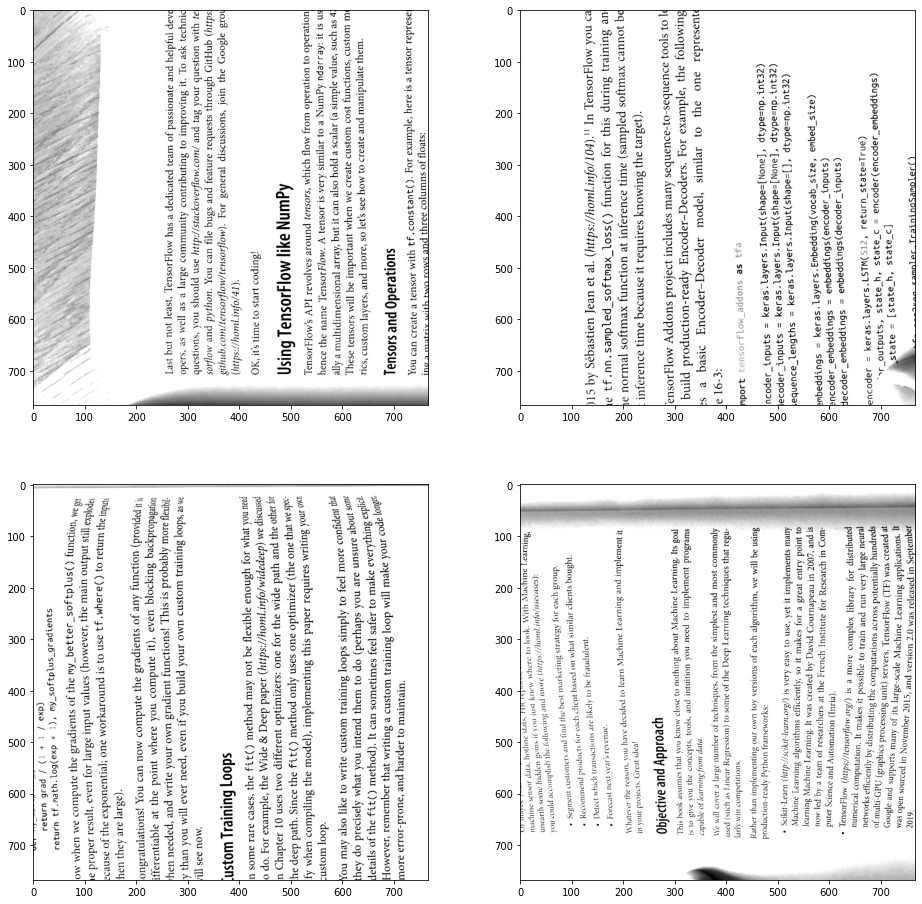

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def preview_images(images_dir, images_num=1, figsize=(15, 15)):
    image_names = os.listdir(images_dir)
    image_names = image_names[:images_num]
    
    num_cells = math.ceil(math.sqrt(images_num))
    figure = plt.figure(figsize=figsize)
    
    for image_index, image_name in enumerate(image_names):
        image_path = os.path.join(images_dir, image_name)
        image = Image.open(image_path)
        
        figure.add_subplot(num_cells, num_cells, image_index + 1)
        plt.imshow(np.asarray(image))
    
    plt.show()

preview_images('dataset/printed_links/processed', images_num=4, figsize=(16, 16))

In [24]:
!labelImg dataset/printed_links/processed/

/bin/bash: labelImg: command not found


In [19]:
import re
import random

def partition_dataset(
    images_dir,
    xml_labels_dir,
    train_dir,
    test_dir,
    val_dir,
    train_ratio,
    test_ratio,
    val_ratio,
    copy_xml
):    
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
        
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    images = [f for f in os.listdir(images_dir)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg|.jpeg|.png)$', f, re.IGNORECASE)]

    num_images = len(images)
    
    num_train_images = math.ceil(train_ratio * num_images)
    num_test_images = math.ceil(test_ratio * num_images)
    num_val_images = math.ceil(val_ratio * num_images)
    
    print('Intended split')
    print(f'  train: {num_train_images}/{num_images} images')
    print(f'  test: {num_test_images}/{num_images} images')
    print(f'  val: {num_val_images}/{num_images} images')
    
    actual_num_train_images = 0
    actual_num_test_images = 0
    actual_num_val_images = 0
    
    def copy_random_images(num_images, dest_dir):
        copied_num = 0
        
        if not num_images:
            return copied_num
        
        for i in range(num_images):
            if not len(images):
                break
                
            idx = random.randint(0, len(images)-1)
            filename = images[idx]
            shutil.copyfile(os.path.join(images_dir, filename), os.path.join(dest_dir, filename))
            
            if copy_xml:
                xml_filename = os.path.splitext(filename)[0]+'.xml'
                shutil.copyfile(os.path.join(xml_labels_dir, xml_filename), os.path.join(dest_dir, xml_filename))
            
            images.remove(images[idx])
            copied_num += 1
        
        return copied_num
    
    actual_num_train_images = copy_random_images(num_train_images, train_dir)
    actual_num_test_images = copy_random_images(num_test_images, test_dir)
    actual_num_val_images = copy_random_images(num_val_images, val_dir)
    
    print('\n', 'Actual split')
    print(f'  train: {actual_num_train_images}/{num_images} images')
    print(f'  test: {actual_num_test_images}/{num_images} images')
    print(f'  val: {actual_num_val_images}/{num_images} images')

partition_dataset(
    images_dir='dataset/printed_links/processed',
    train_dir='dataset/printed_links/partitioned/train',
    test_dir='dataset/printed_links/partitioned/test',
    val_dir='dataset/printed_links/partitioned/val',
    xml_labels_dir='dataset/printed_links/labels/xml',
    train_ratio=0.8,
    test_ratio=0.2,
    val_ratio=0,
    copy_xml=True
)

NameError: ignored

In [21]:
import os
import io
import math
import glob
import tensorflow as tf
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
from collections import namedtuple
from object_detection.utils import dataset_util, label_map_util

tf1 = tf.compat.v1

# Convers labels from XML format to CSV.
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                int(root.find('size')[0].text),
                int(root.find('size')[1].text),
                member[0].text,
                int(member[4][0].text),
                int(member[4][1].text),
                int(member[4][2].text),
                int(member[4][3].text)
            )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def class_text_to_int(row_label, label_map_dict):
    return label_map_dict[row_label]


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


# Creates a TFRecord.
def create_tf_example(group, path, label_map_dict):
    with tf1.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
        
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class'], label_map_dict))

    tf_example = tf1.train.Example(features=tf1.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    
    return tf_example


def dataset_to_tfrecord(
    images_dir,
    xmls_dir, 
    label_map_path,
    output_path,
    csv_path=None
):
    label_map = label_map_util.load_labelmap(label_map_path)
    label_map_dict = label_map_util.get_label_map_dict(label_map)
    
    tfrecord_writer = tf1.python_io.TFRecordWriter(output_path)
    images_path = os.path.join(images_dir)
    csv_examples = xml_to_csv(xmls_dir)
    grouped_examples = split(csv_examples, 'filename')
    
    for group in grouped_examples:
        tf_example = create_tf_example(group, images_path, label_map_dict)
        tfrecord_writer.write(tf_example.SerializeToString())
        
    tfrecord_writer.close()
    
    print('Successfully created the TFRecord file: {}'.format(output_path))
    
    if csv_path is not None:
        csv_examples.to_csv(csv_path, index=None)
        print('Successfully created the CSV file: {}'.format(csv_path))

# Generate a TFRecord for train dataset.
dataset_to_tfrecord(
    images_dir='dataset/printed_links/partitioned/train',
    xmls_dir='dataset/printed_links/partitioned/train',
    label_map_path='dataset/printed_links/labels/label_map.pbtxt',
    output_path='dataset/printed_links/tfrecords/train.record',
    csv_path='dataset/printed_links/labels/csv/train.csv'
)

# Generate a TFRecord for test dataset.
dataset_to_tfrecord(
    images_dir='dataset/printed_links/partitioned/test',
    xmls_dir='dataset/printed_links/partitioned/test',
    label_map_path='dataset/printed_links/labels/label_map.pbtxt',
    output_path='dataset/printed_links/tfrecords/test.record',
    csv_path='dataset/printed_links/labels/csv/test.csv'
)

Successfully created the TFRecord file: dataset/printed_links/tfrecords/train.record
Successfully created the CSV file: dataset/printed_links/labels/csv/train.csv
Successfully created the TFRecord file: dataset/printed_links/tfrecords/test.record
Successfully created the CSV file: dataset/printed_links/labels/csv/test.csv


## 📖 Exploring the Dataset

- Preview images with detection boxes
- Number of images (why is this enough)
- Do we need to preprocess the images

## 📈 Setting Up TensorBoard

- Why do we need it (for debugging)
- What we will monitor

## 👨‍🎓 Transfer Learning

- What is transfer learning
- Why don't we train the model from scratch
- Allows us to use small dataset

### ⚙️ Configuring the Detection Pipeline

- Performance issues: batch size
- Starting not from scratch: checkpoints

### 🏋🏻‍♂️ Model Training

- Error prone: saving checkpoints
- How many epochs
- Monitoring the performance while training

### 🚀 Evaluating the Model

- Checking how accurate our model is on test dataset
- Are we good with performance, should we save the model?
- It is not a general purpose anymore, does it recognize our custom objects?

## 🗜 Exporting the Model

- Saving the model to the file for further re-use
- Show the list of files, how the model looks like on dics
- What the size of the model

## 🚀 Evaluating the Exported Model

- Example of how to use the trained model

## 🗜 Converting the Model for Web

- What formats are sutable for the web
- Few words about Tensorflow.js
- Show list of exported files - how model looks like on disc
- What the size of the model
- Why it is split in chucnks and how they are connected (via model.json)

In [ ]:
pip install tensorflowjs --quiet

     |████████████████████████████████| 71kB 4.1MB/s 
     |████████████████████████████████| 112kB 8.2MB/s 


## 🤔 Conclusions

- I'm just an amatour
- Links to demo app
- Issues and limitations of this approach
- Links to my ML repositories that thy might like